In [1]:
import os
import psutil
import numpy as np
from timeit import default_timer as timer
from matplotlib import pyplot as plt
import cv2
import imghdr
import scipy.ndimage as filters

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback
# import tensorflow_datasets as tfds

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = 'GAN_Custom_Dataset'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(directory='GAN_Custom_Dataset',
                                                 color_mode='grayscale',
                                                 batch_size=32,
                                                 image_size=(28, 28),
                                                 shuffle=True,
                                                 seed=42)
ds = ds.as_numpy_iterator()
ds = next(ds)[0]

Found 39 files belonging to 1 classes.


In [5]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    for _ in range(4):
        model.add(UpSampling2D())
        model.add(Conv2D(128, 5, padding='same'))
        model.add(LeakyReLU(0.2))

    for _ in range(2):
        model.add(Conv2D(128, 4, padding='same'))
        model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [6]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [7]:
# def build_discriminator():
#     model = Sequential()
#
#     # Adding initial convolutional layer & declaring input shape (same as generator output shape; 64x64x1)
#     model.add(Conv2D(32, 4, input_shape = (64,64,1)))
#     model.add(LeakyReLU(0.2))
#     model.add(Dropout(0.4))
#
#     # Adding additional convolutional layers
#     for i in [64, 128, 256]:
#         model.add(Conv2D(i, 5))
#         model.add(LeakyReLU(0.2))
#         model.add(Dropout(0.4))
#
#     # Flattening & passing through a dense layer to output a value between 0 and 1 (0=fake; 1=real)
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(1))
#
#     return model

def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    for i in [64, 128, 256]:
        model.add(Conv2D(i, 5))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [8]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)      

In [9]:
# Creating GAN model class
# Custom class to set custom training loop (instead of using default tensorflow loop)
class GAN(Model):
    # Function to be called when 'GAN' is initialised
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Passing '*args' and '**kwargs' to inherited tensorflow base class init method
        super().__init__(*args, **kwargs)

        # Creating generator and discriminator attributes
        self.generator = generator
        self.discriminator = discriminator

    # Function to compile
    def compile(self, gen_optimiser, disc_optimiser, gen_loss, disc_loss, *args, **kwargs):
        # Passing '*args' and '**kwargs' to inherited tensorflow base class compile method
        super().compile(*args, **kwargs)

        # Creating attributes for losses and optimisers
        self.gen_optimiser = gen_optimiser
        self.disc_optimiser = disc_optimiser
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    # Function to be called when '.fit()' is called (custom training loop)
    def train_step(self, batch):
        # Getting fake & real images
        real_imgs = batch
        fake_imgs = self.generator(tf.random.normal((128, 128, 1)), training=False)
        print(real_imgs.shape)
        print(fake_imgs.shape)

        # Training discriminator
        with tf.GradientTape() as disc_gradient_tape:
            # Passing real & fake images to discriminator and getting model's predictions
            pred_real = self.discriminator(real_imgs, training=True)
            pred_fake = self.discriminator(fake_imgs, training=True)
            pred_real_fake = tf.concat([pred_real,
                                        pred_fake],
                                       axis=0)

            # Labelling real & fake images (real_imgs=0; fake_imgs=1)
            label_real_fake = tf.concat([tf.zeros_like(pred_real),
                                         tf.ones_like(pred_fake)],
                                        axis=0)

            # Adding noise to outputs (results in better training in the long run)
            noise_real = 0.15*tf.random.uniform(tf.shape(pred_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(pred_fake))
            label_real_fake += tf.concat([noise_real,
                                          noise_fake],
                                         axis=0)

            # Calculating loss function
            total_disc_loss = self.disc_loss(label_real_fake, pred_real_fake)

        # Applying discriminator back-propagation (passing output data back as input data)
        disc_gradient = disc_gradient_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
        self.disc_optimiser.apply_gradients(zip(disc_gradient, self.discriminator.trainable_variables))

        #Training generator
        with tf.GradientTape() as gen_gradient_tape:
            # Generating new images
            gen_imgs = self.generator(tf.random.normal((128,128,1)),  training=True)

            # Passing generated images to discriminator (training=False to avoid training both models at the exact same time)
            pred_labels = self.discriminator(gen_imgs, training=False)

            # Calculating loss function
            # Passing generated images as real images and rewarding generator if discriminator believes it
            # Passing fake predictions: 'tf.zeros_like(pred_labels)' & real predictions 'pred_labels'
            total_gen_loss = self.gen_loss(tf.zeros_like(pred_labels), pred_labels)

        # Applying generator back-propagation (passing output data back as input data)
        gen_gradient = gen_gradient_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.gen_optimiser.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"disc_loss":total_disc_loss, "gen_loss":total_gen_loss}

In [10]:
class ModelMonitor(Callback):
    def __init__(self, num_imgs=3, dim=128):
        self.num_imgs = num_imgs
        self.dim = dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 500 == 0:
            rand_latent_vectors = tf.random.uniform((self.num_imgs, self.dim, 1))
            gen_imgs = self.model.generator(rand_latent_vectors)
            gen_imgs *=255
            gen_imgs.numpy()
            for i in range(self.num_imgs):
                img = array_to_img(gen_imgs[i])
                img.save(os.path.join('GAN_Training_Data', f'generated_img_{epoch}_{i}.png'))
            gan.save_weights('Training_Weights/Weights')

In [11]:
# Setting optimiser and loss functions
# discriminator will have a slower learning rate to allow generator to 'catch up'
gen_optimiser = Adam(learning_rate=0.000001)
gen_loss = BinaryCrossentropy()
disc_optimiser = Adam(learning_rate=0.00001)
disc_loss = BinaryCrossentropy()

gan = GAN(generator, discriminator)
gan.compile(gen_optimiser, disc_optimiser, gen_loss, disc_loss)

In [12]:
# Training model
# 2000 epochs recommended
# hist = gan.fit(ds, epochs=20, callbacks=[ModelMonitor()], use_multiprocessing=True)
# hist = gan.fit(ds, callbacks=[ModelMonitor()], epochs=150000)

1/1 [==============================] - 0s 20ms/step
Execution time in MS: 64.06999999990148
Memory usage in MB: 328.1640625


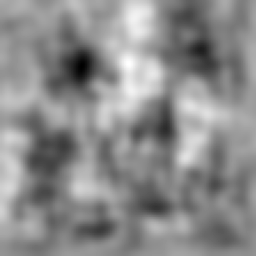

In [42]:
# Starting timer
start = timer()

pred = generator.predict(np.random.randn(1, 128))
img = filters.gaussian_filter(pred[0], sigma=2)

# Ending timer
end = timer()
print("Execution time in MS:", (end-start) * 1000)
print("Memory usage in MB:", psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

plt.figure(figsize=(333, 333), dpi=1)
plt.imshow(img, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig('Outputs/Heightmaps/Diamond_Square_Heightmap.png', bbox_inches='tight', pad_inches=0, dpi=1)
